## Week 2: Gambler's Ruin Problem and Mean Time Spent in Transient States 

* Simulating and analyzing the MC associated with the Gambler's Ruin Problem
* Studying the Mean TIme in Transient States (for Practice Problem)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The Gambler's Ruin Problem

By modifying the 1D Random Walk (cf. week 1), we can simulate a trajectory of the Markov Chain associated with the Gambler's Ruin Problem

Initialization

In [5]:
x = []
# starting with $25
x.append(25)
# amount of money of the bank
N = 50

Simulation

In [6]:
# probability of winning a bet:
p = 0.45

while 0 < x[-1] < N:
    if np.random.rand() <= p:
        # winning $1 bet
        x.append(x[-1] + 1) 
    else:
        # losing $1 bet
        x.append(x[-1] - 1) 

Plotting the outcome of the simulation

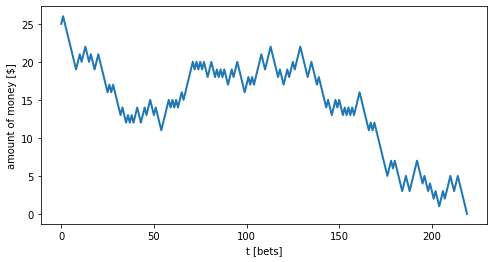

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel("t [bets]")
ax.set_ylabel("amount of money [$]")
ax.plot(x, lw=2)

By simulating the process many times, let's see what's the probability of ruin. We'll see in class how we can find this analyically.

In [8]:
# modify any of these parameters to see what happens
nrealizations = 1000
p = 0.45      # P(winning a bet)
N = 50      # money of bank
x0 = 40      # initial state

realizations = []

for r in range(nrealizations):
    x = [x0]
    while 0 < x[-1] < N:
        if np.random.rand() <= p: # (note that Lebesgue_measure(np.random.rand() = p) = 0)
            # winning $1 bet
            x.append(x[-1] + 1) 
        else:
            # losing $1 bet
            x.append(x[-1] - 1)
    realizations.append(x)

# count the times of ruin
nruins = 0
for x in realizations:
    if x[-1] == 0:
        nruins += 1
        
print("Probability of ruin is approximately", nruins / nrealizations)

Probability of ruin is approximately 0.861


We now study the transient states (cf. lecture) {1, ..., N-1} and the probability of revisiting a state. For a state i, the following block allows to extract, from running M simulations over n steps with initial state i, what is the fraction of trajectories such that i was revisited. We set n large (1000), so the results of the simulations approximate the probability of return.

In [9]:
# modify any of these parameters again to see what happens
M = 1000      # number of simulations
n = 100       # number of steps
p = 0.49      # P(winning a bet)
N = 50      # money of bank
i = 25       # initial state

revisited = np.zeros(M)
for r in range(M):
    x = [i]
    step = 1
    while 0 < x[-1] < N and step <= n and revisited[r] != 1:
        if np.random.rand() <= p: 
            # winning $1 bet
            x.append(x[-1] + 1) 
        else:
            # losing $1 bet
            x.append(x[-1] - 1)
        if x[-1] == i:
            revisited[r] = 1
        step += 1
            
print("Probability of revisiting until nth step is approximately", np.sum(revisited) / M)

Probability of revisiting until nth step is approximately 0.929


Let's also study the average number of times that a trajectory visited state i. The following block allows to extract this value

In [10]:
# modify any of these parameters again to see what happens
M = 1000      # number of simulations
n = 1000       # number of steps
p = 0.49      # P(winning a bet)
N = 50      # money of bank
i = 25      # initial state

visited = np.ones(M)
for r in range(M):
    x = [i]
    step = 1
    while 0 < x[-1] < N and step <= n:
        if np.random.rand() <= p:
            # winning $1 bet
            x.append(x[-1] + 1) 
        else:
            # losing $1 bet
            x.append(x[-1] - 1)
        if x[-1] == i:
            visited[r] += 1
        step += 1

print("Mean number of visiting i =", i, "is", np.sum(visited) / M)

Mean number of visiting i = 25 is 21.651


By experimenting with this multiple times, let's compare the results for different possible values of p

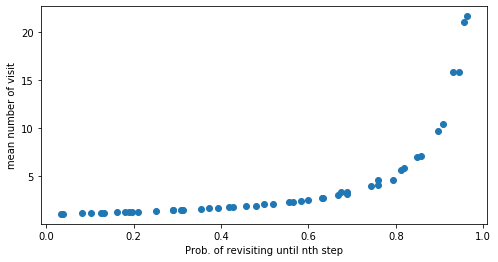

In [11]:
# Varying p
p_array = np.linspace(0.02, 0.98, num=50)

M = 1000      # number of simulations
n = 1000       # number of steps
N = 50      # money of bank
i = 25       # initial state

prob_revis = np.zeros(len(p_array))
mean_nvisit = np.zeros(len(p_array))
for idx, p in enumerate(p_array):
    visited = np.ones(M)
    for r in range(M):
        x = [i]
        step = 1
        while 0 < x[-1] < N and step <= n:
            if np.random.rand() <= p:
                # winning $1 bet
                x.append(x[-1] + 1) 
            else:
                # losing $1 bet
                x.append(x[-1] - 1)
            if x[-1] == i:
                visited[r] += 1
            step += 1
    prob_revis[idx] = len(np.where(visited > 1)[0]) / M
    mean_nvisit[idx] = np.sum(visited) / M

fig1, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.set_xlabel("Prob. of revisiting until nth step")
ax1.set_ylabel("mean number of visit")
ax1.plot(prob_revis, mean_nvisit, lw=0, marker="o")


These simulations suggest these two quantities are related. We'll prove and generalize this more precisely in class!

### Probability of return (see Practice Problem)

 We more generally study in class the probability of return to a state of a Markov Chain. The following blocks allow to estimate for a given state, and after specifying the transition matrix, what is the associated probability of return by simulating the chain multiple times.

First, we import the Markov Chain class defined last week

In [12]:
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.transition_matrix[self.index_dict[current_state], :]
        )
 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

Initialise the Markov chain

In [13]:
#Initialising our Markov chain

transition_matrix =  # Write the transition matrix here e.g. [[0.2, 0.8], [0.7, 0,3]] 
states=  # Name your states here e.g. ['0','1']
markov_chain = MarkovChain(transition_matrix=transition_matrix, states=states) 

We also introduce some useful functions (described in comments)

In [14]:
def run_simulations_markov_chain(markov_chain, nrealizations, nsteps, initial_state):
    sim_arr = np.zeros((nsteps, nrealizations))

    #Running many realizations
    for r in range(nrealizations):
        simulation= markov_chain.generate_states(current_state=initial_state, 
                                              no=nsteps)  
        sim_arr[:, r] = np.array(simulation)
    return sim_arr

def state_statistics(markov_chain, nrealizations, nsteps, initial_state):
    # Return the empirical probability of return and
    # the number of visits of some state 
    # starting from that state. 
    # This is only interesting when the state is transient.
    
    
    # Get the simulation results
    sim_arr = run_simulations_markov_chain(markov_chain, nrealizations, nsteps, initial_state)
    #Here we "call" i the transient initial_state
    N_i = 0
    f_i = 0

    hist = {1:0} # Initialize the histogram as a dictionnary
    sim_arr_transpose = np.transpose(sim_arr)
    for x in sim_arr_transpose:
        occurences_i = np.count_nonzero(x == int(initial_state))# If occurences is 0 then the state is not re-visited
        N_i = N_i + 1 + occurences_i # Add 1 to take into account the intial step X_0 = i
        does_return = (occurences_i>0) 
        f_i = f_i + does_return
        
        if 1+occurences_i in hist:
            hist[1+occurences_i] += 1
        else:
            hist[1+occurences_i] = 1
    return [N_i/nrealizations, f_i/nrealizations,hist]
        

We are now ready to estimate the probability of returning:

In [ ]:
# Compute the probability of returning 
# at some point to state i when starting 
# from state i.

# Choose a transient state
initial_state =  # specify here the state here (use '')
nrealizations = # specify here the number of realizations
nsteps = # specify here the number of steps per realization

# Get its statistics
statistics = state_statistics(markov_chain, nrealizations, nsteps, initial_state)

The following block prints and allow to visualise the results

In [ ]:

# Print the results
print("The empirical average number of visits to " + initial_state + 
      " starting from " + initial_state + " is", statistics[0])
print("The empirical probability of NEVER returning to " + initial_state + 
      " starting from " + initial_state + " is", statistics[1])
hist = statistics[2]

# renormalize the probability distribution
total = sum(hist.values())
factor = 1/total
normalized_hist =  {key:value*factor for key,value in hist.items()}

plt.title('empirical distribution of the number of visits to a transient state')
plt.bar(list(normalized_hist.keys()), normalized_hist.values(), color='g', width=0.4)
plt.show()

### Mean Time in Transient States (see Practice Problem)

We consider here a finite state Markov Chain with a set of transient states numbered as $T= \left\{ 1, 2, \ldots, t \right\} $.

Let us define the transition matrix of transient states $\mathbf{P}_T$, such that $(\mathbf{P}_T)_{ij} = p_{ij} = P(X_1 =j \ | \ X_0=i)$ ($\mathbf{P}_T$ is a sub-matrix of the original full transition matrix of the Markov Chain). 

We also introduce the matrix $\mathbf{S}$ of size $t$, such that $(\mathbf{S})_{ij} = s_{ij}$ is the expected number of times where the Markov Chain is in state $j$, given it starts in state $i$. By conditioning on the initial transition (similarly as what we did when studying the probability of ruin in the Gambler's ruin problem), one can show that 

\begin{equation}
s_{ij} = \delta_{ij} + \sum_{k=1}^t p_{ik} s_{kj},
\end{equation}
which in matrix notation can be written as
\begin{equation}
\mathbf{S} = \mathbf{I} + \mathbf{P}_T \mathbf{S},
\end{equation} 
so 
\begin{equation}
\mathbf{S} = (\mathbf{I} - \mathbf{P}_T)^{-1}
\end{equation}

For a given matrix $\mathbf{P}_T$, the following block computes $\mathbf{S}$ (you can use it to solve practice problems, or find the probability of return $f_i$ associated with transient states (cf. properties of transience seen in class and section 4.6 in Ross textbook)).

In [ ]:
# specify your PT
# PT = ...

S = numpy.linalg.inv(np.identity(PT.shape[0]) - PT)